In [1]:
import gmsh
import numpy as np
import copy
    
GL = 2     # Grados de libertad
E = 30e6   # psi Modulo de elasticidad
v = 0.3    # Módulo de Poisson
p = 1   # Presión interna [psi]

In [2]:
gmsh.initialize()           # Inicializo
gmsh.model.add('Axi')       # Agrego el modelo del ejercicio

In [3]:
Dint = 0.5
Es = 0.5
H = 0.5
lc = 2

p1 = gmsh.model.geo.addPoint(Dint, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(Dint+Es, 0, 0, lc) 
p3 = gmsh.model.geo.addPoint(Dint+Es, H, 0, lc) 
p4 = gmsh.model.geo.addPoint(Dint, H, 0, lc) 
p5 = gmsh.model.geo.addPoint(0, H, 0, lc)
p6 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p7 = gmsh.model.geo.addPoint(0, -Dint, 0, lc) 
p8 = gmsh.model.geo.addPoint(0, -Dint-Es, 0, lc) 
p9 = gmsh.model.geo.addPoint(0, H+Dint, 0, lc) 
p10 = gmsh.model.geo.addPoint(0, H+Dint+Es, 0, lc) 
p11 = gmsh.model.geo.addPoint(Dint, H/2, 0, lc) 
p12 = gmsh.model.geo.addPoint(Dint+Es, H/2, 0, lc) 


l1 = gmsh.model.geo.addLine(p7,p8)
semiDo1 = gmsh.model.geo.addCircleArc(p8,p6,p2)
l2 = gmsh.model.geo.addLine(p2, p12)
l6 = gmsh.model.geo.addLine(p12, p3)
semiUp1 = gmsh.model.geo.addCircleArc(p3,p5,p10)
l3 = gmsh.model.geo.addLine(p10, p9)
semiUp2 = gmsh.model.geo.addCircleArc(p9,p5,p4)
l4 = gmsh.model.geo.addLine(p4, p11)
l5 = gmsh.model.geo.addLine(p11, p1)
semiDo2 = gmsh.model.geo.addCircleArc(p1,p6,p7)


lR = gmsh.model.geo.addLine(p11, p12)

Lim = gmsh.model.geo.addCurveLoop([l1, semiDo1, l2, l6,  semiUp1, l3, semiUp2, l4, l5,  semiDo2])
S = gmsh.model.geo.addPlaneSurface([Lim])

gmsh.model.geo.synchronize()

Pint = gmsh.model.addPhysicalGroup(1, [semiUp2, l4,l5, semiDo2 ])     # Presión interna en Y
gmsh.model.setPhysicalName(1,Pint, "Pint")

EmpUp = gmsh.model.addPhysicalGroup(1, [l3])     
gmsh.model.setPhysicalName(1,EmpUp, "EmpUp")

EmpDo = gmsh.model.addPhysicalGroup(1, [l1])  
gmsh.model.setPhysicalName(1,EmpDo, "EmpDo")

Rig1 = gmsh.model.addPhysicalGroup(1, [lR])
gmsh.model.setPhysicalName(1,Rig1, "Rig")

Trash1 = gmsh.model.addPhysicalGroup(0, [p5])
gmsh.model.setPhysicalName(0,Trash1, "trash1")

Trash2 = gmsh.model.addPhysicalGroup(0, [p6])
gmsh.model.setPhysicalName(0,Trash2, "trash2")

Ntsh1 = gmsh.model.mesh.get_nodes_for_physical_group(1,Trash1)   # Puntos basura
Ntsh2 = gmsh.model.mesh.get_nodes_for_physical_group(1,Trash2)   # Puntos basura
NEmpUp = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpUp) 
NEmpDo = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpDo) 
Npint = gmsh.model.mesh.get_nodes_for_physical_group(1,Pint)   # Nodos de linea presionada

In [4]:
Sup = gmsh.model.addPhysicalGroup(2,[S])
gmsh.model.setPhysicalName(2, Sup, 'Sup')

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)


NTri = gmsh.model.mesh.get_nodes_for_physical_group(2,Sup)   # Nodos de los triangulos
NRig1 = gmsh.model.mesh.get_nodes_for_physical_group(1, Rig1)  # Nodos de eje transversal a z para imponer rigidez
# NRig2 = gmsh.model.mesh.get_nodes_for_physical_group(1, Rig2)  # Nodos de eje transversal a z para imponer rigidez

In [5]:
# Nodos

nodos = gmsh.model.mesh.get_nodes()      # Información de los nodos del mallado
N = nodos[0].shape[0]                    # Número de nodos
MN = nodos[1].reshape(N , 3)             # Matriz de nodos

# Elementos

e_tags, e = gmsh.model.mesh.get_elements_by_type(2)  # Información de los elementos tipo 2 (triangulares)
MC = e.reshape([e_tags.shape[0],3])                  # Matriz de conectividad

# Corrijo la MC para que se pueda graficar la red triangular.
# El problema está en que tiene los index de los nodos, teniendo en cuenta los puntos p5 y p6 que son auxiliares, y la matriz de nodos NTri, no.
MCc = MC.copy()
for j, i in enumerate(MCc):
    for h, k in enumerate(i):
        if k>=6:
            MCc[j][h]-=2
MC=MCc.copy()

# # Traccionados

ent_Pint = gmsh.model.getEntitiesForPhysicalGroup(1, Pint)      # Entidad de elementos traccionados
t1, t2, PintN = gmsh.model.mesh.getElements(1, ent_Pint[0]) 
N_seg = PintN[0].reshape(t2[0].shape[0],2)  # Nodos de cada segmento de la entidad


In [6]:
F = np.zeros((2*N, 1))

Npr = Npint[0]-1

# NprUp=NpintUp[0]-1
# NprDo=NpintDo[0]-1
# NprCent=NpintCent[0]-1


# Tubo abierto:
# F[int(Npr[0]*2)]=np.pi*pr*MN[Npr[0]][0]*(MN[Npr[-1]][1]-MN[Npr[0]][1])
# print(MN[Npr])

# F[int(Npr[1]*2)]=np.pi*pr*MN[Npr[1]][0]*(MN[Npr[1]][1]-MN[Npr[2]][1])


# for i in range(2,len(Npr)-1):
#     Ldown = (MN[Npr[i-1]][1]-MN[Npr[i]][1])             #  L (del segmento abajo del nodo)
#     Lup = (MN[Npr[i]][1]-MN[Npr[i+1]][1])               #  L (del segmento arriba del nodo)
#     print(Ldown, Lup)
#     F[int(Npr[i]*2)]=np.pi*pr*MN[Npr[i]][0]*(Ldown+Lup)
# i=len(Npr)-1
# Ldown = (MN[Npr[i]][1]-MN[Npr[0]][1])               #  L (del segmento abajo del nodo)
# Lup = (MN[Npr[i-1]][1]-MN[Npr[i]][1])                  #  L (del segmento arriba del nodo)
# F[int(Npr[i]*2)]=np.pi*pr*MN[Npr[i]][0]*(Ldown+Lup)

# Tubo cerrado:

# A cada nodo le sumo la componente de la fuerza en r y z (o sea en nodo*2 y nodo*2+1)
for i, n in enumerate(N_seg):
    n1=MN[n[0]]
    n2=MN[n[1]]
    L = np.sqrt((n1[1]-n2[1])**2 + (n1[0]-n2[0])**2)
    F[int(n[0]*2)]+=p*np.pi*n1[0]*(n1[0]-n2[0])                      # r   uso que (r2-r1)/L = cos(angulo entre p y pr)
    F[int(n[0]*2+1)]+=p*np.pi*n1[0]*(n1[1]-n2[1])                      # z   uso que (z2-z1)/L = sen(angulo entre p y pr)ç
    F[int(n[1]*2)]+=p*np.pi*n1[0]*(n1[0]-n2[0])                      # r   uso que (r2-r1)/L = cos(angulo entre p y pr)
    F[int(n[1]*2+1)]+=p*np.pi*n1[0]*(n1[1]-n2[1])                      # z   uso que (z2-z1)/L = sen(angulo entre p y pr)

Fu = F[::2]; Fw = F[1::2]

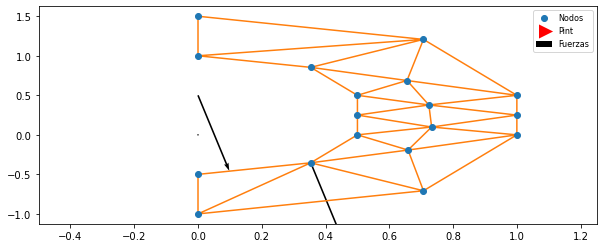

In [7]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10,4))
plt.rc('axes', labelsize=10 )
plt.rc('xtick', labelsize=10 )
plt.rc('ytick', labelsize=10 )
plt.rc('legend', fontsize=8)
plt.xlim([-Dint, Dint+Es+ Es/2])
plt.plot(MN[NTri[0]-1, 0], MN[NTri[0]-1,1], 'o', label='Nodos')
plt.triplot(MN[NTri[0]-1,0], MN[NTri[0]-1,1], MC-1)
# plt.triplot(NT0, NT1, MCc-1)
plt.plot(MN[Npint[0]-1, 0], MN[Npint[0]-1, 1,],"r>", markeredgewidth=5, label='Pint' )
plt.quiver(MN[:,0], MN[:,1], Fu, Fw, units='x',scale=4, width=0.005, label="Fuerzas")
# plt.quiver(MN[Long_trac[::2].reshape(len(Long_trac)+1,1)-1, 0], MN[Long_trac[::2].reshape(len(Long_trac)+1,1)-1, 1],  Fx[Long_trac[::2].reshape(len(Long_trac)+1,1)[:,0]-1], Fy[Long_trac[::2].reshape(len(Long_trac)+1,1)[:,0]-1],scale=800, units="x", width=0.05, label='Tracción')

plt.legend()

In [8]:
el = len(MC)      # cantidad de elementos
K = np.zeros([N*GL, N*GL])
Bs=[]
D = (E/((1+v)*(1-2*v))) * np.array([[1-v,v,v,0],[v,1-v,v,0],[v,v,1-v,0],[0,0,0,(1-2*v)/2]])

for q in range(el):     # Recorro los triangulos
    B = np.zeros([4,6])
    c = []              #coordenadas de los nodos del elemento
    for i in MC[q]:
        aux=MN[int(i-1)].copy()
        aux[2]=1
        c.append(aux)
    b=[0,0,0]; g=[0,0,0]; a=[0,0,0]
    A = np.linalg.det(c)/2           # Probar sin un menos
    for d in range(3): 
        a[d] = (c[d-2][0] * c[d-1][1] - c[d-2][1] * c[d-1][0])
        b[d] = c[d-2][1]- c[d-1][1]
        g[d] = c[d-1][0]- c[d-2][0]
    rc=0; zc=0
    for i in range(3):
        rc+=c[i][0]/3
        zc+=c[i][1]/3
    for j in range(3):
        B[0][j*2]+=b[j]
        B[1][2*j+1]+=g[j]
        B[3][j*2]+=g[j]
        B[3][j*2+1]+=b[j]
        B[2][j*2]=a[j]/rc + b[j] + g[j]*zc/rc
    B = B/(2*A)
    Bs.append(B)
    k = 2* np.pi *rc *A*np.dot(np.dot(B.transpose(), D), B)
    for i in range(3):
        nx=int(MC[q][i]-1)
        for j in range(3):
            ny=int(MC[q][j]-1)
            K[np.ix_([nx*2,nx*2+1], [ny*2,ny*2+1])]+=k[i*2:i*2+2, j*2:j*2+2]
# K[np.abs(K)<1e-5]=0             
# np.round(K/1e6, 2)

In [9]:
# Impido el desplazamiento de una linea horizontal en z y para las linea verticales en r. Ademas de los puntos auxiliares.
s = np.hstack([(NRig1[0]-1)*2+1, (Ntsh1[0]-1)*2, 
               (Ntsh1[0]-1)*2+1, (Ntsh2[0]-1)*2, 
               (Ntsh2[0]-1)*2+1, (NEmpUp[0]-1)*2, (NEmpDo[0]-1)*2] )   
r = np.delete( np.arange(2*N) , s )

dd = np.linalg.solve(K[np.ix_(r,r)], F[r])  # Desplazamientos resultantes

d = np.zeros((2*N, 1))
d[r] = dd

Ffinal=K.dot(d)   # Fuerzas resultantes
Ffinal[np.array(Ffinal)<1e-5]=0

LinAlgError: Singular matrix

In [ ]:
Du = d[::2]; Dw = d[1::2]

Fu = Ffinal[::2]; Fw = Ffinal[1::2]
# np.round(Du/1e-6, 4), np.round(Dw/1e-6, 4)


In [ ]:
plt.rc('figure', figsize=(15,5))
plt.rc('axes', labelsize=10 )
plt.rc('xtick', labelsize=10 )
plt.rc('ytick', labelsize=10 )
plt.rc('legend', fontsize=10)
plt.triplot(MN[NTri[0]-1, 0], MN[NTri[0]-1, 1], MC-MC.min())
plt.xlim([0, 5*H/2])
plt.quiver(MN[:,0], MN[:,1], Fu, Fw, units='x',scale=4, width=0.005, label="Fuerzas")
plt.quiver(MN[:,0], MN[:,1], Du, Dw, Dw, color="g", width=0.003, label="Desplazamientos")  # Cambiar el color a uno uniforme? Scale?
plt.legend()

In [ ]:
Esf=[]
for i in range(len(MC)):
    jj=np.array(MC[i]-1)*2 
    index=[jj[0],jj[0]+1,jj[1],jj[1]+1,jj[2],jj[2]+1]
    Esf.append( np.dot( np.dot(D,Bs[i]), d[np.array(index,  dtype=int)])) 
Esf=np.array(Esf)
Esf=Esf.transpose()
Esf=Esf[0]

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
# fig, ax = plt.subplots(1,1, figsize=(10,5))
cmap = ax1.tripcolor(MN[NTri[0]-1,0],MN[NTri[0]-1,1],MC-MC.min(), facecolors=Esf[0], edgecolor='k',linewidth=0.05)
cbar = plt.colorbar(cmap, ax=ax1)
cmap = ax2.tripcolor(MN[NTri[0]-1,0],MN[NTri[0]-1,1],MC-MC.min(), facecolors=Esf[1], edgecolor='k',linewidth=0.05)
cbar = plt.colorbar(cmap, ax=ax2)
cmap = ax3.tripcolor(MN[NTri[0]-1,0],MN[NTri[0]-1,1],MC-MC.min(), facecolors=Esf[2], edgecolor='k',linewidth=0.05)
cbar = plt.colorbar(cmap, ax=ax3)
cmap = ax4.tripcolor(MN[NTri[0]-1,0],MN[NTri[0]-1,1],MC-MC.min(), facecolors=Esf[3], edgecolor='k',linewidth=0.05)
cbar = plt.colorbar(cmap)
# plt.savefig("lp-0.01.jpg")